# Sequence Dispersion Minimization

"Phase dispersion minimization" (PDM) is a period-finding method where we don't assume the shape of signals, only  that they are periodic, and search over a grid of periods to find one that produces the smallest dispersion at a given phase-folding. The problem is appealing b/c we don't care about *when* the pattern begins, so long as it's strictly repeating.

Instead, what if we didn't have signals that were simply periodic, but repeating using other sequences of separation (e.g. [integer sequences](https://en.wikipedia.org/wiki/Integer_sequence))? Assuming a particular sequence (e.g. [Fibonacci](https://en.wikipedia.org/wiki/Fibonacci_number), or maybe something more interesting like [Kolakoski](https://en.wikipedia.org/wiki/Kolakoski_sequence)), we can search over a "periods" (actually characteristic timescales) and sequence start times. It's not as trivial as PDM, but it's conceptually similar to [BLS](https://docs.astropy.org/en/stable/timeseries/bls.html), and I bet there are tricks we can play to speed it up. Example: for scaling sequences like Fibonacci, we can limit our search volume based on our data's properties.

So let's explore **Sequence Dispersion Minimization**!

_musings_

I'm still wondering, if you picked up the Kolakoski sequence 100 steps into the sequence, would you be able to predict the next timing separation given N observations?

In [1]:
# %matplotlib inline
import numpy as np
import pandas as pd
# where I'm writing down the functions I'm re-using
from stuff import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

Text(0, 0.5, 'Flux')

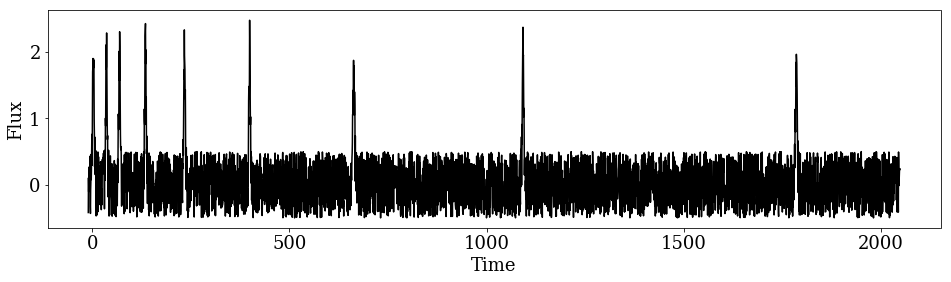

In [3]:
# let's make a Fib-spaced light curve pulse sequence

std = 2
tau = 33
amp = 2.
t0 = 3

time = np.arange(-10, 2048, 0.5)

flux = np.random.random(len(time))*1 - 0.5 
flux = flux + fib_gaus1(time, tau, amp, std, t0=t0)

plt.figure(figsize=(16,4))
plt.plot(time, flux, c='k')
plt.xlabel('Time')
plt.ylabel('Flux')
# plt.savefig('big_lc.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

Text(0, 0.5, 'Flux')

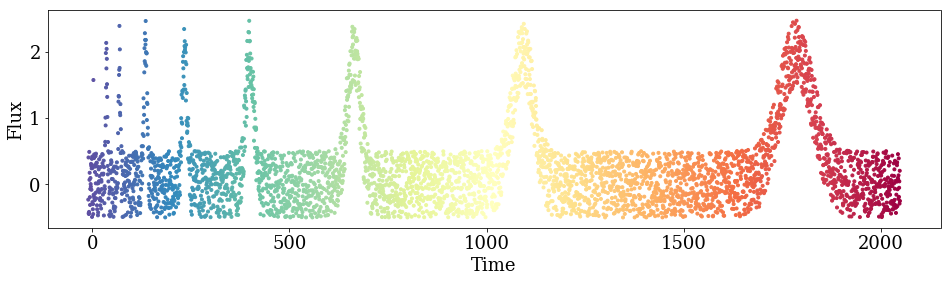

In [4]:
# and now, what if we scale the width of the gaussian as well...

flux2 = np.random.random(len(time))*1 - 0.5 
flux2 = flux2 + fib_gaus2(time, tau, amp, std, t0=t0, Nfib=9)

plt.figure(figsize=(16,4))
plt.scatter(time, flux2, c=time, marker='.', cmap=plt.cm.Spectral_r)
plt.xlabel('Time')
plt.ylabel('Flux')

(-0.5, 0.5)

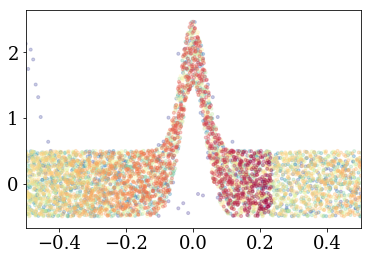

In [5]:
# we can of course reconstruct the gaussians, and overlay them all

fib_seq = fib(10) * tau
for k in range(1,len(fib_seq)):
    pp = (time - (t0 + np.cumsum(fib_seq)[k-1])) / ((1+fib_seq[k])/tau)
    plt.scatter(pp/tau, flux2, c=time, marker='.', cmap=plt.cm.Spectral_r, alpha=0.3)
plt.xlim(-0.5, 0.5)


(-0.5, 0.5)

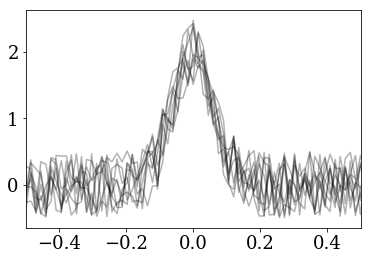

In [6]:
# and the same trick works with the non-scaled gaussians too, but w/o scaling the folded timeseries

fib_seq = fib(10) * tau
for k in range(1,len(fib_seq)):
    pp = (time - (t0 + np.cumsum(fib_seq)[k-1])) #/ ((1+fib_seq[k])/tau)
    plt.plot(pp/tau, flux, alpha=0.3, c='k')
plt.xlim(-0.5, 0.5)



In [7]:
tau

33

(-0.5, 0.5)

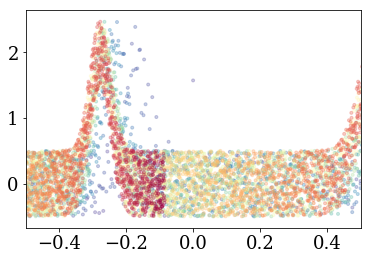

In [8]:
# this is driven by only 1 number: the Fibonacci timescale we've used. Here's the overlay w/ wrong "tau"
tau_i = 40.
fib_seq_i = fib(10) * tau_i
for k in range(1,len(fib_seq)):
    pp = (time - (t0 + np.cumsum(fib_seq_i)[k-1])) / ((1+fib_seq_i[k])/tau_i)
    plt.scatter(pp/tau_i, flux2, c=time, marker='.', cmap=plt.cm.Spectral_r, alpha=0.3)
plt.xlim(-0.5, 0.5)


(-0.5, 0.5)

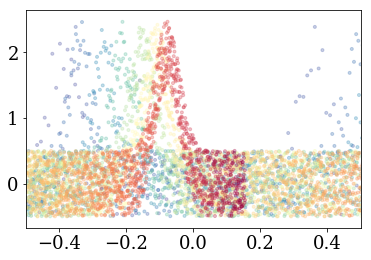

In [9]:
# this is driven by only 1 number: the Fibonacci timescale we've used. Here's the overlay w/ wrong "tau"
tau_i = 33
t0new = 10

fib_seq_i = fib(10) * tau_i + t0new
for k in range(1,len(fib_seq)):
    pp = (time - (np.cumsum(fib_seq_i)[k-1])) / ((1+fib_seq_i[k])/tau_i)
    plt.scatter(pp/tau_i, flux2, c=time, marker='.', cmap=plt.cm.Spectral_r, alpha=0.3)
plt.xlim(-0.5, 0.5)



(-0.5, 0.5)

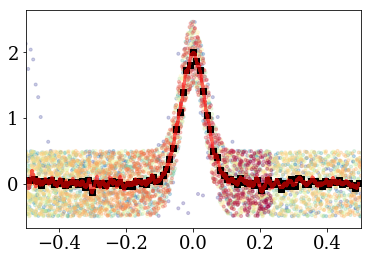

In [10]:
# meaning we can JUST search over "tau" (and t_0, which I'm ignoring so far), and measure the dispersion!
# let's measure the dispersion for a single tau, and build this up...

from scipy.stats import binned_statistic

tau_i = 33.

x_i = np.array([])
y_i = np.array([])

fib_seq_i = fib(10) * tau_i
for k in range(1,len(fib_seq)):
    scale = (1 + fib_seq_i[k]) / tau_i
    pp = (time - (t0 + np.cumsum(fib_seq_i)[k-1])) / scale
    ok = np.where((pp/tau_i >= -0.5) & (pp/tau_i <= 0.5))[0]
    x_i = np.append(x_i, pp[ok]/tau_i)
    y_i = np.append(y_i, flux2[ok])
    
    plt.scatter(pp/tau_i, flux2, c=time, marker='.', cmap=plt.cm.Spectral_r, alpha=0.3)

Nbins = 100
bin_means, bin_edges, binnumber = binned_statistic(x_i, y_i, statistic='mean', bins=np.linspace(-0.5, 0.5, Nbins))
bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2

plt.scatter(bin_centers, bin_means, c='k', marker=',')

ss_i = np.argsort(x_i)
plt.plot(x_i[ss_i], pd.Series(y_i[ss_i]).rolling(int(len(y_i)/100), center=True).mean().values, 
         lw=3, c='r', alpha=0.6)
plt.xlim(-0.5, 0.5)


In [11]:
%%timeit
y1 = pd.Series(y_i[ss_i]).rolling(int(len(y_i)/50), center=True).mean().values

496 µs ± 42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%%timeit

Nbins = 50
bin_means, bin_edges, binnumber = binned_statistic(x_i, y_i, statistic='mean', bins=np.linspace(-0.5, 0.5, Nbins))
bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2

y2 = np.interp(x_i, bin_centers, bin_means)

347 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


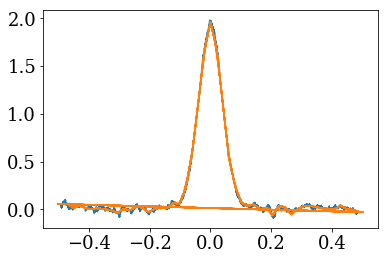

In [13]:
y1 = pd.Series(y_i[ss_i]).rolling(int(len(y_i)/50), center=True).mean().values

Nbins = 50
bin_means, bin_edges, binnumber = binned_statistic(x_i, y_i, statistic='mean', bins=np.linspace(-0.5, 0.5, Nbins))
bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2
y2 = np.interp(x_i, bin_centers, bin_means)

plt.plot(x_i[ss_i], y1)
plt.plot(x_i, y2)

In [14]:
error = np.ones_like(flux2)*0.6

tau_grid = np.arange(3, 99, 1)
t0_grid = np.linspace(-10, 50, 100)

print(tau_grid.shape, t0_grid.shape)

(96,) (100,)


In [15]:
%%prun -s cumulative -q -l 50 -T prun0
psd = SDM_search(time, flux2, error, tau_grid, t0=[t0])

 
*** Profile printout saved to text file 'prun0'. 


In [16]:
# print(open('prun0', 'r').read())

Text(0.5, 1.0, 'SDM power spectrum')

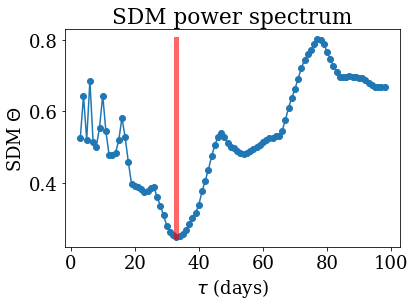

In [17]:
plt.plot(tau_grid, psd, '-o')
plt.plot([tau, tau], [psd.min(), psd.max()], lw=5, alpha=0.6, c='r')
plt.ylabel('SDM $\Theta$')
plt.xlabel(r'$\tau$ (days)')
plt.title('SDM power spectrum')

Text(0.5, 1.0, 'SDM power spectrum')

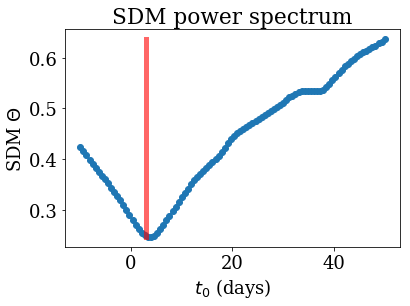

In [18]:
psd = SDM_search(time, flux2, error, [33.], t0=t0_grid)[0]
plt.plot(t0_grid, psd, '-o')
plt.plot([t0, t0], [psd.min(), psd.max()], lw=5, alpha=0.6, c='r')
plt.ylabel('SDM $\Theta$')
plt.xlabel(r'$t_0$ (days)')
plt.title('SDM power spectrum')

In [19]:
%%prun -s cumulative -q -l 50 -T prun1
psd_2d = SDM_search(time, flux, error, tau_grid, t0_grid)

 
*** Profile printout saved to text file 'prun1'. 


In [20]:
# print(open('prun1', 'r').read())

Text(0.5, 1.0, 'SDM power spectrum')

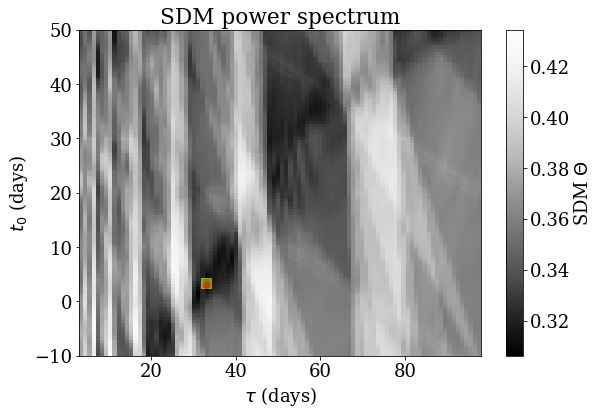

In [21]:
plt.figure(figsize=(9,6))
plt.imshow(psd_2d.T, origin='lower', aspect='auto', cmap=plt.cm.Greys_r, 
           extent=[min(tau_grid), max(tau_grid), min(t0_grid), max(t0_grid)])

cb = plt.colorbar()
cb.set_label('SDM $\Theta$')

b_ind = np.unravel_index(psd_2d.argmin(), psd_2d.shape)
plt.scatter(tau_grid[b_ind[0]], t0_grid[b_ind[1]], alpha=0.5, c='yellow', s=100, marker='s')

plt.scatter(tau, t0, c='red', alpha=0.5)

plt.xlabel(r'$\tau$ (days)')
plt.ylabel(r'$t_0$ (days)')
plt.title('SDM power spectrum')

In [22]:
print(tau_grid[b_ind[0]], t0_grid[b_ind[1]])
print(tau, t0)

33 3.333333333333334
33 3


In [23]:
psd_2d = SDM_search(time, flux2, error, tau_grid, t0_grid)

Text(0.5, 1.0, 'SDM power spectrum')

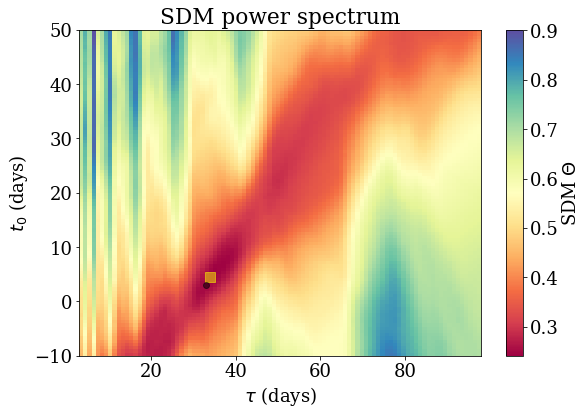

In [24]:
plt.figure(figsize=(9,6))
plt.imshow(psd_2d.T, origin='lower', aspect='auto', cmap=plt.cm.Spectral, 
           extent=[min(tau_grid), max(tau_grid), min(t0_grid), max(t0_grid)])

cb = plt.colorbar()
cb.set_label('SDM $\Theta$')

b_ind = np.unravel_index(psd_2d.argmin(), psd_2d.shape)
plt.scatter(tau_grid[b_ind[0]], t0_grid[b_ind[1]], alpha=0.5, c='yellow', s=100, marker='s')

plt.scatter(tau, t0, c='k', alpha=0.5)

plt.xlabel(r'$\tau$ (days)')
plt.ylabel(r'$t_0$ (days)')
plt.title('SDM power spectrum')

## So, it works

It generally works. And it seems to work for both the scaled and un-scaled input data, even with scaling turned "on"... ok!

Now another Q: can we detect the right input parameters given only a portion of the sequence?

Can we find degenerate answers?

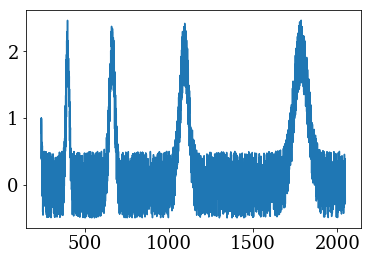

In [25]:
plt.plot(time[500:], flux2[500:])

In [26]:
psd_2d = SDM_search(time[500:], flux2[500:], error[500:], tau_grid, t0_grid)

35 5.757575757575758


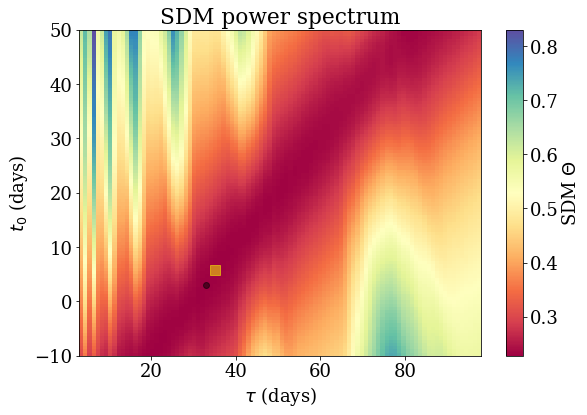

In [27]:
plt.figure(figsize=(9,6))
plt.imshow(psd_2d.T, origin='lower', aspect='auto', cmap=plt.cm.Spectral, 
           extent=[min(tau_grid), max(tau_grid), min(t0_grid), max(t0_grid)])

cb = plt.colorbar()
cb.set_label('SDM $\Theta$')

b_ind = np.unravel_index(psd_2d.argmin(), psd_2d.shape)
plt.scatter(tau_grid[b_ind[0]], t0_grid[b_ind[1]], alpha=0.5, c='yellow', s=100, marker='s')

plt.scatter(tau, t0, c='k', alpha=0.5)

plt.xlabel(r'$\tau$ (days)')
plt.ylabel(r'$t_0$ (days)')
plt.title('SDM power spectrum')

print(tau_grid[b_ind[0]], t0_grid[b_ind[1]])

In [28]:
tau_grid = np.logspace(1, 2., 100) # np.arange(3, 99, 1)
t0_grid = np.logspace(-1, 2., 100) # np.linspace(-10, 50, 100)

print(np.shape(tau_grid), np.shape(t0_grid))

(100,) (100,)


In [29]:
psd_2d = SDM_search(time[500:], flux[500:], error[500:], tau_grid, t0_grid)

29.836472402833405 3.0538555088334154
33 3


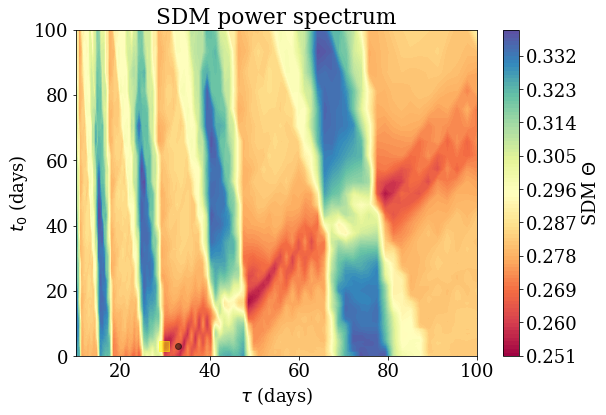

In [30]:
plt.figure(figsize=(9,6))
# plt.imshow(psd_2d.T, origin='lower', aspect='auto', cmap=plt.cm.Spectral, 
#            extent=[min(tau_grid), max(tau_grid), min(t0_grid), max(t0_grid)])

plt.contourf(tau_grid, t0_grid, psd_2d.T, cmap=plt.cm.Spectral, levels=100)

cb = plt.colorbar()
cb.set_label('SDM $\Theta$')

b_ind = np.unravel_index(psd_2d.argmin(), psd_2d.shape)
plt.scatter(tau_grid[b_ind[0]], t0_grid[b_ind[1]], alpha=0.5, c='yellow', s=100, marker='s')
plt.scatter(tau, t0, c='k', alpha=0.5)

plt.xlabel(r'$\tau$ (days)')
plt.ylabel(r'$t_0$ (days)')
plt.title('SDM power spectrum')

# plt.xscale('log')
# plt.yscale('log')

print(tau_grid[b_ind[0]], t0_grid[b_ind[1]])
print(tau, t0)